# <center>CNN Assignment - Skin Cancer Prediction</center>

### Assignment Brief

To build a CNN based model which can accurately detect __melanoma__. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.
The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

# <center>Importing Required Libraries</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
import os
import pathlib
from glob import glob


# Turning warnings off
import warnings
warnings.filterwarnings('ignore')

# <center>Mounting and Uploading Data</center>

In [2]:
# Code for mounting and uploading data on Google Drive
# Uncomment below code if you want to use it

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In below cell, we are changing current directory to Dataset directory which will be our working directory.

Uncomment below cell to run it.

In [6]:
#cd gdrive/MyDrive/DeepLearning/Datasets

/content/gdrive/MyDrive/DeepLearning/Datasets


# <center>Data Reading/Data Understanding</center>

Defining the paths for train and test images

In [7]:
train_dir = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
test_dir = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
# Printing count of number of images in train and test dataset
imageCount_train = len(list(train_dir.glob('*/*.jpg')))
print('Number of training images : ' + str(imageCount_train))
imageCount_test = len(list(test_dir.glob('*/*.jpg')))
print('Number of test images : ' + str(imageCount_test))
print('Total number images : ' + str(imageCount_train + imageCount_test))

Number of training images : 2239
Number of test images : 118
Total number images : 2357


Total number of images are 2357 which is equal to number of images mentioned for our data. Hence, we are able to read all images correctly.

# <center>Dataset Creation</center>

Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

### Create a dataset

Defining some parameters for the loader.

In [9]:
batch_size = 32
img_height = 180
img_width = 180

We will be using train dataset and perform a 80:20 split for seperating training data from validation data.

We will be using using **tf.keras.preprocessing.image_dataset_from_directory** library.

In [10]:
## Defining training dataset
## We will use seed=123 while creating training dataset using tf.keras.preprocessing.image_dataset_from_directory
## We will resize our image to size 180*180
trainDataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               batch_size=batch_size,
                                                               image_size=(img_height, img_width),
                                                               seed=123, validation_split=0.2,
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Defining validation dataset
## We will use seed=123 while creating validation dataset using tf.keras.preprocessing.image_dataset_from_directory
## We will resize our image to size 180*180
validationDataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                             batch_size=batch_size,
                                                             image_size=(img_height, img_width),
                                                             seed=123, validation_split=0.2,
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# Listing out all the training and validation classes of skin cancer and storing them in a list
trainingClasses = trainDataset.class_names
validationClasses = validationDataset.class_names
print('Training Classes : '+ str(trainingClasses))
print('Validation Classes : '+ str(validationClasses))

Training Classes : ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Validation Classes : ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In above cell output we can see classes belonging to train and test dataset. In below section we will visualize one instance/image from each of the classes.

# <center>Dataset visualisation</center>

Create a code to visualize one instance of all the nine classes present in the dataset.

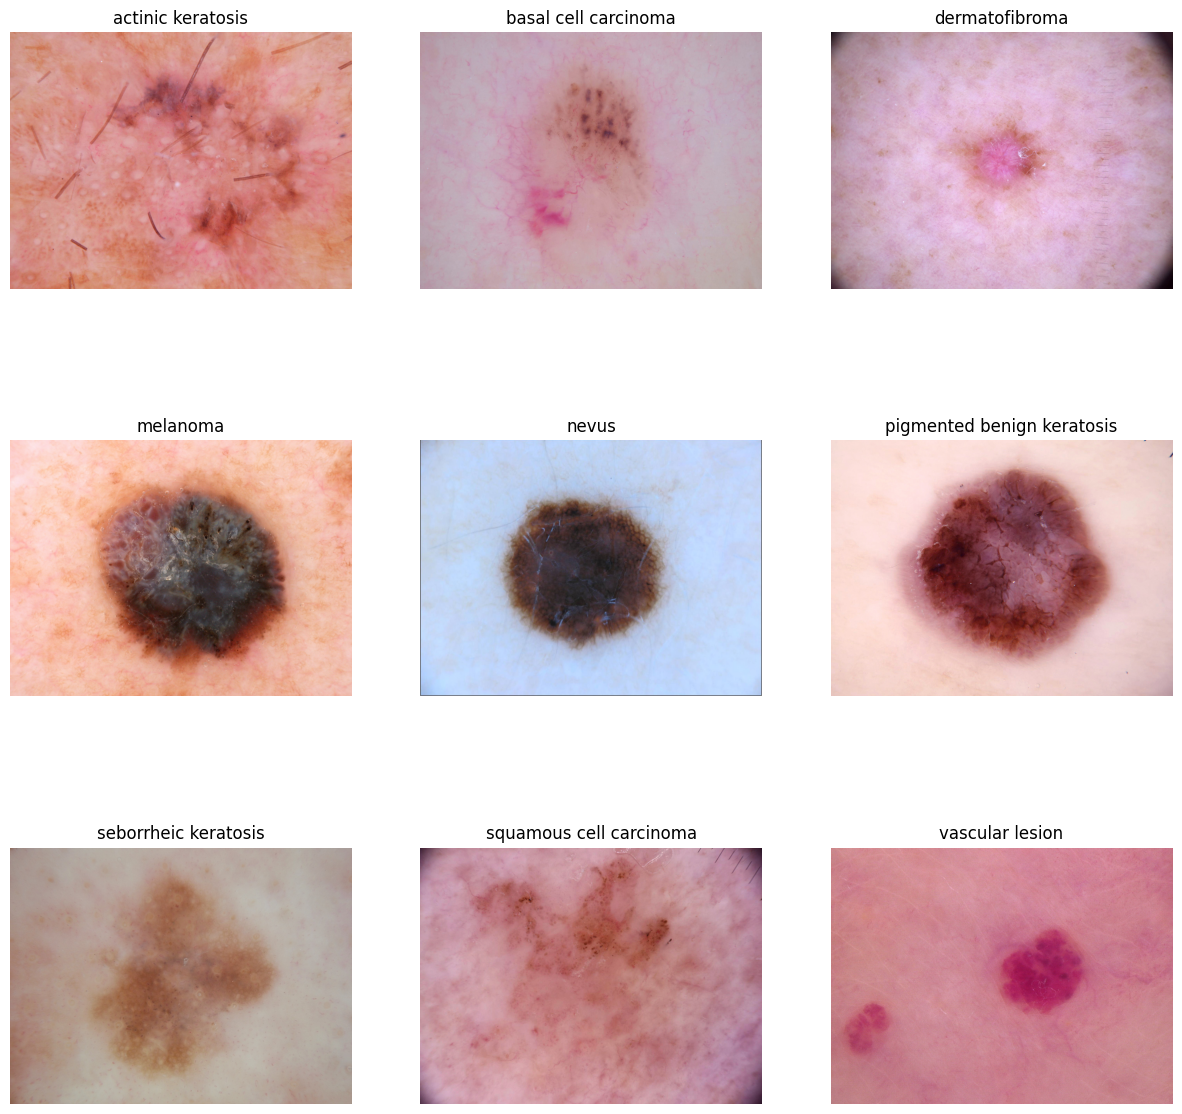

In [13]:
# Setting figure size
plt.figure(figsize=(15, 15))

# Fetching first image from each class and plotting them in subplots
for index, className in enumerate(trainingClasses):

  plt.subplot(3, 3, index+1)
  diseaseClass = list(train_dir.glob(className+'/*'))

  # Reading Image
  image = plt.imread(diseaseClass[0])

  # Plotting Image
  plt.imshow(image)
  plt.title(className)

  # Turning axis off
  plt.axis("off")

From above visualization, we can observe that there is a stark difference between all the images belonging to various classes.

Now we have read and visualized the images. We will now move on to model building phase in next section.

# <center>Configuring the dataset for performance</center>

In [14]:
# Printing shape of image and labels batches
for image_batch, labels_batch in trainDataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3) where each of the 32 images in batche is of shape 180x180x3 whereas the label_batch is a tensor of the shape (32,) where each label represent the class image belongs to.

We will use buffered prefetching so that we can yield data from disk without having I/O become blocking issue. Two important methods we will use when loading data are as follows:

1. **Dataset.cache()** keeps the images in memory after they are loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache.

2. **Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [15]:
# Intializing AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# Applying AUTOTUNE for improving performance on train and validation datasets
# AUTOTUNE automatically calculates optimal buffer size
trainDataset = trainDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validationDataset = validationDataset.cache().prefetch(buffer_size=AUTOTUNE)

# <center>Model Building & training</center>

- Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
- Choose an appropriate optimiser and loss function for model training
- Train the model for ~20 epochs
- Write your findings after the model fit, see if there is evidence of model overfit or underfit

### Creating CNN Model

In [16]:
# Importing Required Libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of classes
outputClasses = 9

# Defining Model
model = Sequential([

  # Defining the preprocessing layer for rescaling images
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Defining 3 sets of Conv2D and MaxPooling Layers
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(512, 3, activation='relu'),
  layers.MaxPooling2D(),

  # Defining Flatten layer which converts a matix to it's vector counterpart
  layers.Flatten(),

  # Defining Fully connected and Output layer
  layers.Dense(512, activation='relu'),
  layers.Dense(outputClasses, activation='softmax')
])

Our model consists of 3 convolution blocks with a max pool layer in each of them, 2 dense layers and a fully connected layer with 128 units on top of it that is activated by a relu activation function.<br><br>

### Compiling Model

In below code, we will compile our model by using Adam Optimizer and loss function as Categorical Cross Entropy. We are using accuracy as metrics.

In [17]:
# Compiling Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Printing Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Training Model

In [18]:
# Defining number of epochs
epochs = 20

# Fitting and running the model
history = model.fit(
  trainDataset,
  validation_data=validationDataset,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 584s 3s/step - loss: 2.0056 - accuracy: 0.2405 - val_loss: 1.8905 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.7700 - accuracy: 0.3404 - val_loss: 1.7014 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 2s 44ms/step - loss: 1.5991 - accuracy: 0.4180 - val_loss: 1.5108 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4882 - accuracy: 0.4654 - val_loss: 1.4250 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4319 - accuracy: 0.4905 - val_loss: 1.6693 - val_accuracy: 0.3893
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4088 - accuracy: 0.5022 - val_loss: 1.4182 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3204 - accuracy: 0.5234 - val_loss: 1.4665 - val_accuracy: 0.4676
Epoch 8/20
56

### Visualizing training results

Creating plots of loss and accuracy on the training and validation sets.

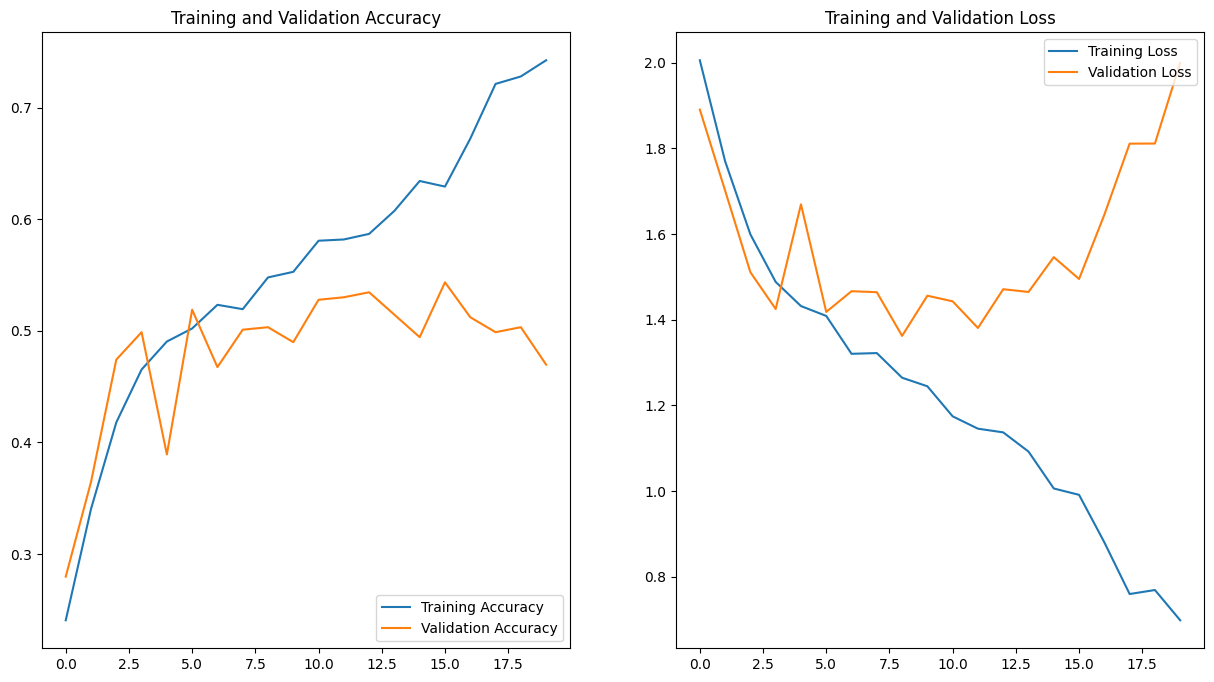

In [19]:
# Fetching various performance metrics
trainingAccuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']
trainingLoss = history.history['loss']
validationLoss = history.history['val_loss']

# Defining range of epochs
epochRange = range(epochs)

# Plotting Training Accuracy VS Validation Accuracy
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochRange, trainingAccuracy, label='Training Accuracy')
plt.plot(epochRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training Loss VS Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochRange, trainingLoss, label='Training Loss')
plt.plot(epochRange, validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from above plots, training accuracy and validation accuracy are having huge difference. After 20 epochs, model is having good accuracy on training dataset but on validation, accuracy is very low which is clearly indicating the phenomena of **overfitting**.

Training accuracy is increasing linearly over epochs, whereas validation accuracy stalls around 50% - 60% in the training process.

# <center>Choose an appropriate Data Augmentation Strategy to resolve Underfitting/Overfitting</center>

In deep learning overfitting normally occurs due to small amount of training data. With data augmentation, we can generate additional training data from existing training data by augmenting them using random transformations. This helps expose the model to more aspects of the data and generalize better.

In [20]:
# Defining Augmentaion layer for performing random horizontal flipping/vertical flipping/roatation
dataAugmentorLayer = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomFlip("vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
  ]
)

In below cell, we will visualize how our augmentation strategy works for one instance of training image.

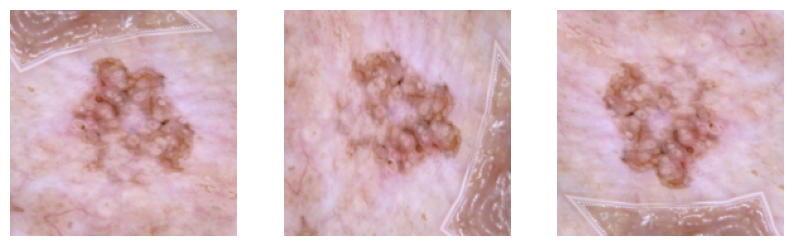

In [21]:
# Defining Figure Size
plt.figure(figsize=(10, 10))

# Reading first batch of training data
for images, _ in trainDataset.take(1):

  # Defining number of times we want to apply augmentation i.e 3
  for i in range(3):
    # Applying augmentation to whole batch
    augmented_images = dataAugmentorLayer(images)

    ax = plt.subplot(3, 3, i + 1)

    # Plotting augmented image
    plt.imshow(augmented_images[16].numpy().astype("uint8"))
    plt.axis("off")

# <center>Model Building & training on the augmented data</center>

Creating and training the same model with little modification. In order to reduce overfitting, we will be training on more data by augmenting the data.

To handle overfitting, we will also introduce dropout between our layers for purpose of model regularization.

In [22]:
# Importing Required Libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of classes
outputClasses = 9

# Defining Model
augmentedModel = Sequential([

  # Adding data augmentor layer
  dataAugmentorLayer,

  # Defining the preprocessing layer for rescaling images
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Defining 3 sets of Conv2D, MaxPooling Layers and dropouts among them
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),

  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(512, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # Defining Flatten layer which converts a matix to it's vector counterpart
  layers.Flatten(),

  # Defining Fully connected and Output layer
  layers.Dense(512, activation='relu'),
  layers.Dense(outputClasses, activation='softmax')
])

In [23]:
# Compiling Model
augmentedModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Printing Model Summary
augmentedModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 89, 89, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 128)       73856     
                                                      

In [24]:
# Defining number of epochs
epochs = 20

# Fitting and running the model
history = augmentedModel.fit(
  trainDataset,
  validation_data=validationDataset,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 153ms/step - loss: 2.5324 - accuracy: 0.2054 - val_loss: 2.0393 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 7s 128ms/step - loss: 1.9840 - accuracy: 0.2483 - val_loss: 2.0884 - val_accuracy: 0.2148
Epoch 3/20
56/56 [==============================] - 7s 127ms/step - loss: 1.8752 - accuracy: 0.3008 - val_loss: 1.8598 - val_accuracy: 0.2908
Epoch 4/20
56/56 [==============================] - 7s 129ms/step - loss: 1.7811 - accuracy: 0.3214 - val_loss: 1.7752 - val_accuracy: 0.3065
Epoch 5/20
56/56 [==============================] - 7s 128ms/step - loss: 1.6888 - accuracy: 0.3700 - val_loss: 1.5945 - val_accuracy: 0.4318
Epoch 6/20
56/56 [==============================] - 7s 130ms/step - loss: 1.6199 - accuracy: 0.4157 - val_loss: 1.6010 - val_accuracy: 0.4541
Epoch 7/20
56/56 [==============================] - 8s 135ms/step - loss: 1.5768 - accuracy: 0.4364 - val_loss: 1.5380 - val_accuracy: 0.4765
Epoch

### Visualizing training results

Creating plots of loss and accuracy on the training and validation sets.

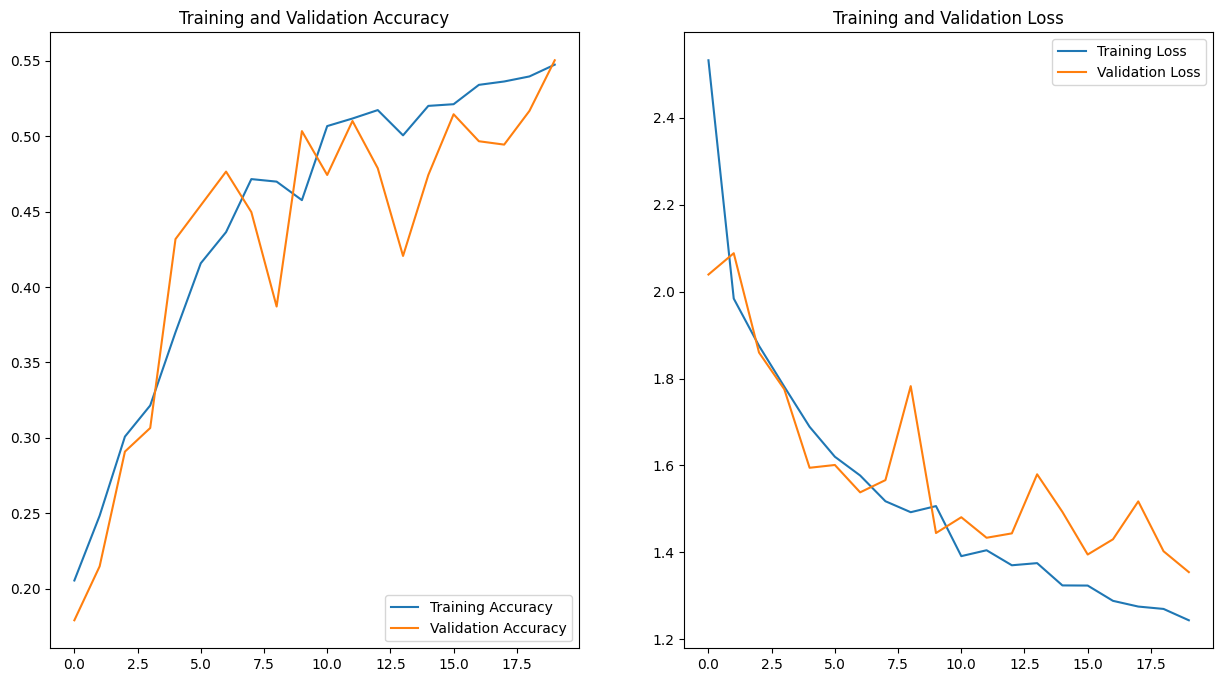

In [25]:
# Fetching various performance metrics
trainingAccuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']
trainingLoss = history.history['loss']
validationLoss = history.history['val_loss']

# Defining range of epochs
epochRange = range(epochs)

# Plotting Training Accuracy VS Validation Accuracy
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochRange, trainingAccuracy, label='Training Accuracy')
plt.plot(epochRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training Loss VS Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochRange, trainingLoss, label='Training Loss')
plt.plot(epochRange, validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After adding dropouts and augmentation layers, we can observe from above plots that now model is not overfitting as training and validation accuracy are very much similar to each other.

# <center>Class distribution</center>

Examine the current class distribution in the training dataset
- Which class has the least number of samples?
- Which classes dominate the data in terms of the proportionate number of samples?

In [26]:
# Defining total number of classes
numberOfClasses = len(trainingClasses)

# Function to count number of images in each classes
def getClassCount(counts, batch, num_classes=numberOfClasses):

    # Fetching labels
    labels = batch[1]

    # Updating counts of each class
    for i in range(num_classes):
        classCount = tf.cast(labels == i, tf.int32)
        counts[trainingClasses[i]] += tf.reduce_sum(classCount)
    return counts

In [27]:
# Creating dictionary where classes are keys and counts are intialised as value equal to zero
initialState = dict((trainingClasses[i], 0) for i in range(numberOfClasses))

# Reducing training dataset
counts = trainDataset.reduce(initial_state=initialState, reduce_func=getClassCount)

# Calculating total number of images in training dataset by multiplying total number of batches with number of images in each batch
totalImages = len(trainDataset)*32

# Printing distribution of various class in training dataset
for k, v in counts.items():
  classCountPercentage = round((v.numpy()/totalImages)*100, 2)
  print(k.capitalize() +' : ' + str(classCountPercentage) + '%')

Actinic keratosis : 5.13%
Basal cell carcinoma : 17.24%
Dermatofibroma : 4.3%
Melanoma : 19.64%
Nevus : 15.46%
Pigmented benign keratosis : 20.65%
Seborrheic keratosis : 3.24%
Squamous cell carcinoma : 7.92%
Vascular lesion : 6.42%


__In above cell, we have printed distribution of each class in training dataset.__

*   **Seborrheic keratosis** is the class with least number of samples.
*   Below are the classes which dominate the data in terms of the proportionate number of samples :
  1. **Pigmented benign keratosis** (20.65%)
  2. **Melanoma** (19.64%)
  3. **Basal cell carcinoma** (17.24%)
  4. **Nevus** (15.46%)

<br>
From above cell, we can infer that there is a clear class imbalancing in our data and it needs to be handled which we will do from next section.




# <center>Handling class imbalances</center>
Rectify class imbalances present in the training dataset with Augmentor library.

In [28]:
# Installing External Augmentor library for purpose of generating more training dataset
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a set of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
# Importing Augmentor Library
import Augmentor

# Performing Augmentation on training data for each class
for classDir in trainingClasses:

    # Defining input for pipeline
    pipeline = Augmentor.Pipeline(str(train_dir) + '/' + classDir)

    # Applying rotation and random fli  pping transformations
    pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    pipeline.flip_random(probability=0.7)

    # We are adding 500 samples per class to make sure that none of the classes are sparse.
    pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3BB84E7F70>: 100%|██████████| 500/500 [00:24<00:00, 20.11 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3BB85C2590>: 100%|██████████| 500/500 [00:20<00:00, 23.91 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3BB83436A0>: 100%|██████████| 500/500 [00:20<00:00, 24.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3BB863BEB0>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F3C20362110>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3BC41184F0>: 100%|██████████| 500/500 [00:20<00:00, 24.02 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F3C203A2080>: 100%|██████████| 500/500 [00:41<00:00, 11.96 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3C204FA620>: 100%|██████████| 500/500 [00:18<00:00, 26.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3BB84E8400>: 100%|██████████| 500/500 [00:20<00:00, 24.07 Samples/s]


Augmentor Pipeline has stored the augmented images in the output sub-directory of each of the sub-directories/class directories of skin cancer types. Lets take a look at total count of augmented images.

In [30]:
# Printing total number of augmented images generated
generatedAugmentedImages = len(list(train_dir.glob('*/output/*.jpg')))
print(generatedAugmentedImages)

4500


# Class Distribution After Augmented Images Addition In Training Data

In [31]:
# Defining original images paths and their corresponding labels list
originalImagesPaths = [path for path in glob(os.path.join(train_dir, '*', '*.jpg'))]
originalImagesLabels = [os.path.basename(os.path.dirname(path)) for path in glob(os.path.join(train_dir, '*', '*.jpg'))]

# Defining dictionary mapping original paths to respective labels
originalPathsLabelsMapping = dict(zip(originalImagesPaths, originalImagesLabels))

# Defining Dataframe mapping original paths to respective labels
originalPathsLabelsMapping_DF = pd.DataFrame(list(originalPathsLabelsMapping.items()),columns = ['Path','Label'])

In [32]:
# Defining augmented images paths and their corresponding labels list
augmentedImagesPaths = [path for path in glob(os.path.join(train_dir, '*', 'output', '*.jpg'))]
augmentedImagesLabels = [os.path.basename(os.path.dirname(os.path.dirname(path))) for path in glob(os.path.join(train_dir, '*', 'output', '*.jpg'))]

# Defining dictionary mapping augmented paths to respective labels
augmentedPathsLabelsMapping = dict(zip(augmentedImagesPaths, augmentedImagesLabels))

# Defining Dataframe mapping augmented paths to respective labels
augmentedPathsLabelsMapping_DF = pd.DataFrame(list(augmentedPathsLabelsMapping.items()),columns = ['Path','Label'])

In [33]:
# Appending augmented paths mapping to original paths mapping
Orignal_Augmented_Paths = originalPathsLabelsMapping_DF.append(augmentedPathsLabelsMapping_DF)

# Printing samples of combined dataframe
Orignal_Augmented_Paths.sample(5)

,Path,Label
1328,Skin cancer ISIC The International Skin Imagin...,nevus
1221,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
559,Skin cancer ISIC The International Skin Imagin...,melanoma
95,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
2358,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis


Now, we have generated augmented images to handle the issue of class imbalance. Let's see in below cell what's the class distribution now after applying augmentation.

In [34]:
# Printing proportion of images belonging to every class
round(Orignal_Augmented_Paths['Label'].value_counts(1)*100, 2)

pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: Label, dtype: float64

From above class distributions, we can conclude that now our class distribution seems to be much balanced and we can move on to building model again.

# <center>Model Building & Training on Rectified Class Imbalance Data</center>

Before we build model, we need to update our trainDataset and validationDataset with paths for new augmented images.

In [35]:
## Updating training dataset
## We will use seed=123 while creating training dataset using tf.keras.preprocessing.image_dataset_from_directory
## We will resize our image to size 180*180
trainDataset_Updated = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               batch_size=batch_size,
                                                               image_size=(img_height, img_width),
                                                               seed=123, validation_split=0.2,
                                                               subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [36]:
## Updating validation dataset
## We will use seed=123 while creating validation dataset using tf.keras.preprocessing.image_dataset_from_directory
## We will resize our image to size 180*180
validationDataset_Updated = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                             batch_size=batch_size,
                                                             image_size=(img_height, img_width),
                                                             seed=123, validation_split=0.2,
                                                             subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Now, we have updated our training dataset and we will use buffered prefetching so that we can yield data from disk without having I/O become blocking issue.

In [37]:
# Intializing AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# Applying AUTOTUNE for improving performance on train and validation datasets
# AUTOTUNE automatically calculates optimal buffer size
trainDataset_Updated = trainDataset_Updated.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validationDataset_Updated = validationDataset_Updated.cache().prefetch(buffer_size=AUTOTUNE)

In below cell, we will build our final model which will be trained on original Images as well as augmented images.

In [38]:
# Number of classes
outputClasses = 9

# Defining Model
finalModel = Sequential([

  # Using Augmentation layer we defined previously
  dataAugmentorLayer,

  # Defining the preprocessing layer for rescaling images
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Defining 3 sets of Conv2D, MaxPooling Layers and dropouts among them
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),

  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(512, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # Defining Flatten layer which converts a matix to it's vector counterpart
  layers.Flatten(),

  # Defining Fully connected and Output layer
  layers.Dense(512, activation='relu'),

  layers.Dense(outputClasses, activation='softmax')
])

In [39]:
# Compiling Model
finalModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Printing Model Summary
finalModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 89, 89, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 128)       73856     
                                                      

In [40]:
# Defining number of epochs
epochs = 50

# Fitting and running the model
history = finalModel.fit(
  trainDataset_Updated,
  validation_data=validationDataset_Updated,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 63s 183ms/step - loss: 2.2963 - accuracy: 0.1272 - val_loss: 2.1883 - val_accuracy: 0.1359
Epoch 2/50
169/169 [==============================] - 22s 127ms/step - loss: 2.1721 - accuracy: 0.1415 - val_loss: 2.1005 - val_accuracy: 0.1930
Epoch 3/50
169/169 [==============================] - 21s 126ms/step - loss: 1.8782 - accuracy: 0.2865 - val_loss: 1.6393 - val_accuracy: 0.3615
Epoch 4/50
169/169 [==============================] - 21s 126ms/step - loss: 1.6199 - accuracy: 0.3763 - val_loss: 1.4684 - val_accuracy: 0.4373
Epoch 5/50
169/169 [==============================] - 21s 125ms/step - loss: 1.5597 - accuracy: 0.3885 - val_loss: 1.5935 - val_accuracy: 0.3593
Epoch 6/50
169/169 [==============================] - 21s 125ms/step - loss: 1.5074 - accuracy: 0.4084 - val_loss: 1.6234 - val_accuracy: 0.3541
Epoch 7/50
169/169 [==============================] - 21s 124ms/step - loss: 1.4555 - accuracy: 0.4240 - val_loss: 1.3835 - val_ac

### Visualizing training results

Creating plots of loss and accuracy on the training and validation sets.

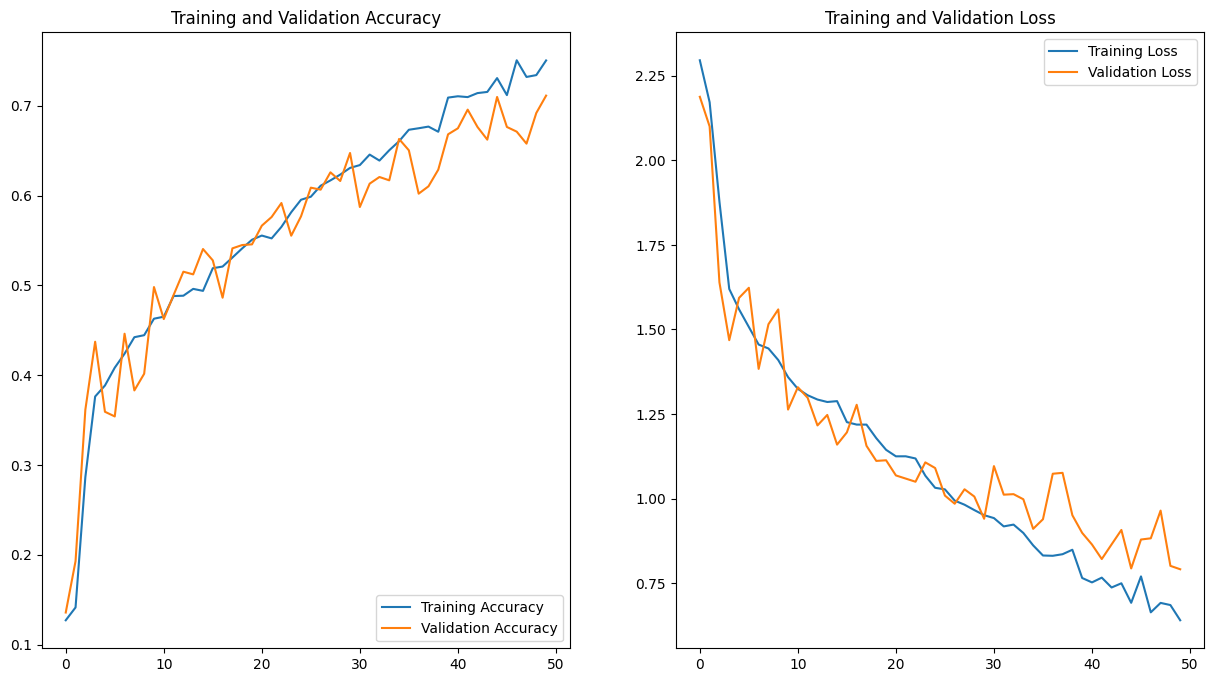

In [41]:
# Fetching various performance metrics
trainingAccuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']
trainingLoss = history.history['loss']
validationLoss = history.history['val_loss']

# Defining range of epochs
epochRange = range(epochs)

# Plotting Training Accuracy VS Validation Accuracy
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochRange, trainingAccuracy, label='Training Accuracy')
plt.plot(epochRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Training Loss VS Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochRange, trainingLoss, label='Training Loss')
plt.plot(epochRange, validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We have handled class imbalance in data by increasing the number of images belonging to each class. We have added 500 training samples to each class.

Once augmentaion is done, we have built our model and we can observe from above plots that now model is not overfitting or underfitting as training and validation accuracy are very much similar to each other.

<mark>**Model is having decent accuracy on both training and validation dataset. With this, we have come to the end of building our skin cancer i.e. Melanoma prediction model**.</mark>